# 1. Entropy drift, take 2

In [1]:
import os
import sys
sys.path.append('../examples')
sys.path.append('../jobs')
sys.path.append('../training_data')

from tqdm import trange

import torch
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

from transformers import GPT2LMHeadModel, GPT2Tokenizer, GPT2Config
from generate_with_entropy import sample_sequence, sample_sequence_batch

import logging
logging.getLogger('transformers.tokenization_utils').setLevel(logging.ERROR)

To use data.metrics please install scikit-learn. See https://scikit-learn.org/stable/index.html


In [2]:
# setup cell

def set_seed(seed=42, n_gpu=0):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if n_gpu > 0:
        torch.cuda.manual_seed_all(args.seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpus = torch.cuda.device_count()

set_seed()
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2LMHeadModel.from_pretrained('gpt2')
model.to(device)
model.eval()

vocab_size = tokenizer.vocab_size

01/10/2020 21:21:44 - INFO - transformers.configuration_utils -   loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/gpt2-config.json from cache at /u/myhu/.cache/torch/transformers/4be02c5697d91738003fb1685c9872f284166aa32e061576bbe6aaeb95649fcf.085d5f6a8e7812ea05ff0e6ed0645ab2e75d80387ad55c1ad9806ee70d272f80
01/10/2020 21:21:44 - INFO - transformers.configuration_utils -   Model config {
  "attn_pdrop": 0.1,
  "embd_pdrop": 0.1,
  "finetuning_task": null,
  "initializer_range": 0.02,
  "is_decoder": false,
  "layer_norm_epsilon": 1e-05,
  "n_ctx": 1024,
  "n_embd": 768,
  "n_head": 12,
  "n_layer": 12,
  "n_positions": 1024,
  "num_labels": 1,
  "output_attentions": false,
  "output_hidden_states": false,
  "output_past": true,
  "pruned_heads": {},
  "resid_pdrop": 0.1,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": true,
  "summary_type": "cls_index",
  "summary_use_proj": true,
  "torchscript": false,
  "use_bf

In [3]:
# generation, no truncation

file = '../training_data/gbw/test/100_lines.txt'
# file = '../training_data/cats.txt'
length = 100

In [4]:
# full gen, take 2
# turned off gradients for entropy, imported other method to deal with combining batches.
k = 0

with torch.no_grad():
    avg_ents = torch.zeros((1, length), device=device)
    i = 0
    with open(file) as fp:
        for line in fp:
            context = tokenizer.encode(line)
            ents = sample_sequence_batch(
                model=model,
                context=context,
                length=length,
                tokenizer=tokenizer,
                temperature=0.968,
                top_k=k,
                top_p=0.0,
                batch_size=32,
                num_samples=128,
                is_xlnet=False,
                device=device
            )
            ents = ents.mean(axis=0)
            avg_ents = (avg_ents * i + ents) / (i + 1)
            i += 1

100%|██████████| 100/100 [00:06<00:00,  8.82it/s]


100%|██████████| 100/100 [00:07<00:00,  7.97it/s]


100%|██████████| 100/100 [00:07<00:00,  7.97it/s]


In [ ]:
test = avg_ents.cpu().numpy()[0]

In [7]:
save_ents = np.zeros((2, length))
save_ents[0, :] = avg_ents.cpu().numpy()[0]

In [35]:
# full gen, take 2
# turned off gradients for entropy, imported other method to deal with combining batches.
k = 0

with torch.no_grad():
    avg_ents = torch.zeros((1, length), device=device)
    i = 0
    with open(file) as fp:
        for line in fp:
            context = tokenizer.encode(line)
            ents = sample_sequence_batch(
                model=model,
                context=context,
                length=length,
                tokenizer=tokenizer,
                temperature=0.9957,
                top_k=k,
                top_p=0.0,
                batch_size=32,
                num_samples=128,
                is_xlnet=False,
                device=device
            )
            ents = ents.mean(axis=0)
            avg_ents = (avg_ents * i + ents) / (i + 1)
            i += 1

100%|██████████| 100/100 [00:08<00:00,  7.83it/s]


100%|██████████| 100/100 [00:08<00:00,  7.83it/s]


In [ ]:
save_ents[1, :] = avg_ents.cpu().numpy()[0]

In [5]:
test = avg_ents.cpu().numpy()[0]

In [6]:
test

array([4.311859 , 3.2606726, 4.508349 , 4.335308 , 4.0716095, 4.009079 ,
       4.048694 , 3.99438  , 4.0095677, 3.9273312, 3.9775162, 3.9449072,
       3.9137213, 3.921588 , 3.9147732, 3.9454672, 3.918662 , 3.9095676,
       3.9032774, 3.9698126, 3.8626213, 3.9403152, 3.92582  , 3.87785  ,
       3.8824575, 3.9401388, 3.8485234, 3.8916125, 3.868392 , 3.9209883,
       3.84818  , 3.8942132, 3.8994741, 3.9062161, 3.8610508, 3.8854473,
       3.8462503, 3.8794906, 3.878317 , 3.843504 , 3.904806 , 3.8884306,
       3.8554196, 3.8937094, 3.852156 , 3.900298 , 3.8633876, 3.9118373,
       3.839064 , 3.8395584, 3.9394193, 3.862866 , 3.8754344, 3.9006686,
       3.870331 , 3.8882134, 3.8739047, 3.9099615, 3.868539 , 3.9063148,
       3.884498 , 3.849898 , 3.891457 , 3.9137442, 3.829405 , 3.838981 ,
       3.8612616, 3.9349759, 3.8293304, 3.889849 , 3.899593 , 3.8284893,
       3.8657405, 3.8634667, 3.8837903, 3.8853402, 3.835264 , 3.832107 ,
       3.8979082, 3.8723936, 3.9231055, 3.9175596, 

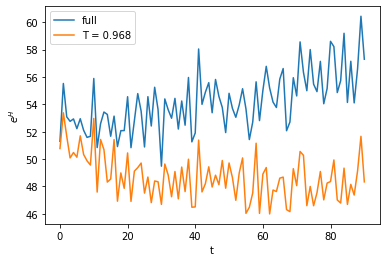

In [9]:
plt.plot(np.exp(old_ents[0, 9:]), label='full')
plt.plot(np.exp(test[9:]), label='T = 0.968')
plt.xlabel('t')
plt.ylabel('$e^H$')
plt.legend()

In [7]:
old_ents = np.load('cache_2.npz')['save_ents']

In [16]:
old_ents

array([[4.31185913, 3.31412601, 4.50743532, 4.2947135 , 4.10369492,
        4.08028507, 4.04924679, 4.01917267, 4.00587511, 3.93768573,
        4.01686716, 3.97195506, 3.96574521, 3.96906352, 3.95553946,
        3.96937943, 3.95324111, 3.94329762, 3.94477463, 4.02342081,
        3.92876387, 3.96239066, 3.97855043, 3.97530699, 3.94487214,
        3.97295046, 3.93017173, 3.95273209, 3.95285583, 3.99929404,
        3.92860866, 3.96660113, 4.00342894, 3.97977471, 3.9296124 ,
        3.99936628, 3.95927882, 4.01188755, 3.98208904, 3.90161085,
        3.99632716, 3.9816792 , 3.97004604, 3.99706197, 3.95503569,
        3.99352717, 3.96040034, 4.02471781, 3.93691158, 3.94955134,
        4.06126881, 3.98901749, 4.00529861, 4.01794195, 3.97757411,
        4.02212381, 3.99966764, 3.98482251, 3.95005798, 4.00384283,
        3.9834857 , 3.97135973, 3.9881978 , 4.00994301, 3.98275447,
        3.94017053, 3.96475792, 4.01904583, 3.9667809 , 4.00765181,
        4.03917027, 4.01085138, 3.99210739, 3.98

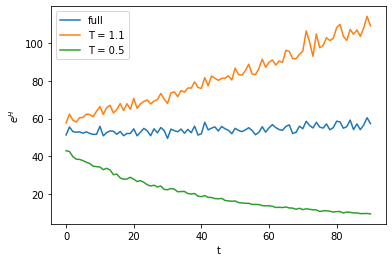

In [33]:
plt.plot(np.exp(old_ents[0, 9:]), label='full')
plt.plot(np.exp(save_ents[0, 9:]), label='T = 1.1')
plt.plot(np.exp(save_ents[1, 9:]), label='T = 0.5')
plt.xlabel('t')
plt.ylabel('$e^H$')
plt.legend()

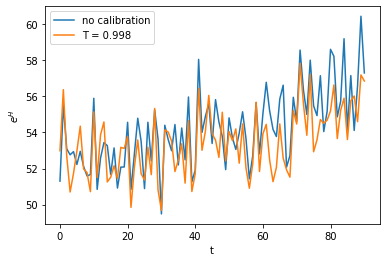

In [44]:
plt.plot(np.exp(old_ents[0, 9:]), label='no calibration')
plt.plot(np.exp(test[9:]), label='T = 0.998')
plt.xlabel('t')
plt.ylabel('$e^H$')
plt.legend()

In [32]:
print(np.exp(old_ents[0, 9]) - np.exp(old_ents[0, 99]))
print(np.exp(old_ents[1, 9]) - np.exp(old_ents[1, 99]))
print(np.exp(old_ents[2, 9]) - np.exp(old_ents[2, 99]))
print(np.exp(old_ents[3, 9]) - np.exp(old_ents[3, 99]))

print(np.exp(save_ents[0, 9]) - np.exp(save_ents[0, 99]))
print(np.exp(save_ents[1, 9]) - np.exp(save_ents[1, 99]))

-5.999499543954741
3.7595398832868767
7.80402569139995
15.791028414201364
-51.532396485853134
33.51401993997917


In [42]:
print(np.exp(test[9]) - np.exp(test[99]))



-3.8675232


In [ ]:
# full gen, take 2
# turned off gradients for entropy, imported other method to deal with combining batches.
k = 0

with torch.no_grad():
    avg_ents = torch.zeros((1, length), device=device)
    i = 0
    with open(file) as fp:
        for line in fp:
            context = tokenizer.encode(line)
            ents = sample_sequence_batch(
                model=model,
                context=context,
                length=length,
                tokenizer=tokenizer,
                temperature=1,
                top_k=k,
                top_p=0.0,
                batch_size=32,
                num_samples=128,
                is_xlnet=False,
                device=device
            )
            ents = ents.mean(axis=0)
            avg_ents = (avg_ents * i + ents) / (i + 1)
            i += 1

In [6]:
save_ents = np.zeros((5, length))
save_ents[0, :] = avg_ents.cpu().numpy()[0]

In [ ]:
# full gen, take 2
k = 2048

with torch.no_grad():
    avg_ents = torch.zeros((1, length), device=device)
    i = 0
    with open(file) as fp:
        for line in fp:
            context = tokenizer.encode(line)
            ents = sample_sequence_batch(
                model=model,
                context=context,
                length=length,
                tokenizer=tokenizer,
                temperature=1,
                top_k=k,
                top_p=0.0,
                batch_size=32,
                num_samples=128,
                is_xlnet=False,
                device=device
            )
            ents = ents.mean(axis=0)
            avg_ents = (avg_ents * i + ents) / (i + 1)
            i += 1

In [8]:
save_ents[1, :] = avg_ents.cpu().numpy()[0]

In [ ]:
# full gen, take 2
k = 512

with torch.no_grad():
    avg_ents = torch.zeros((1, length), device=device)
    i = 0
    with open(file) as fp:
        for line in fp:
            context = tokenizer.encode(line)
            ents = sample_sequence_batch(
                model=model,
                context=context,
                length=length,
                tokenizer=tokenizer,
                temperature=1,
                top_k=k,
                top_p=0.0,
                batch_size=32,
                num_samples=128,
                is_xlnet=False,
                device=device
            )
            ents = ents.mean(axis=0)
            avg_ents = (avg_ents * i + ents) / (i + 1)
            i += 1

In [11]:
save_ents[2, :] = avg_ents.cpu().numpy()[0]

In [ ]:
# full gen, take 2
k = 128

with torch.no_grad():
    avg_ents = torch.zeros((1, length), device=device)
    i = 0
    with open(file) as fp:
        for line in fp:
            context = tokenizer.encode(line)
            ents = sample_sequence_batch(
                model=model,
                context=context,
                length=length,
                tokenizer=tokenizer,
                temperature=1,
                top_k=k,
                top_p=0.0,
                batch_size=32,
                num_samples=128,
                is_xlnet=False,
                device=device
            )
            ents = ents.mean(axis=0)
            avg_ents = (avg_ents * i + ents) / (i + 1)
            i += 1

In [ ]:
save_ents[3, :] = avg_ents.cpu().numpy()[0]

In [ ]:
# full gen, take 2
k = 40

with torch.no_grad():
    avg_ents = torch.zeros((1, length), device=device)
    i = 0
    with open(file) as fp:
        for line in fp:
            context = tokenizer.encode(line)
            ents = sample_sequence_batch(
                model=model,
                context=context,
                length=length,
                tokenizer=tokenizer,
                temperature=1,
                top_k=k,
                top_p=0.0,
                batch_size=32,
                num_samples=128,
                is_xlnet=False,
                device=device
            )
            ents = ents.mean(axis=0)
            avg_ents = (avg_ents * i + ents) / (i + 1)
            i += 1

In [29]:
save_ents[4, :] = avg_ents.cpu().numpy()[0]

In [3]:
save_ents = np.load('cache_2.npz')['save_ents']

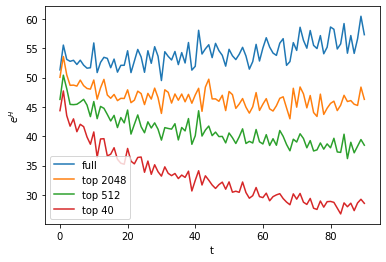

In [34]:
# why is there this weird spike at token 3 or so?
a = 9
plt.plot(np.exp(old_ents[0, a:]), label='full')
plt.plot(np.exp(old_ents[1, a:]), label='top 2048')
plt.plot(np.exp(old_ents[2, a:]), label='top 512')
plt.plot(np.exp(old_ents[4, a:]), label='top 40')
plt.xlabel('t')
plt.ylabel('$e^H$')
plt.legend()

Text(0.5, 1.0, 'Entropy blowup')

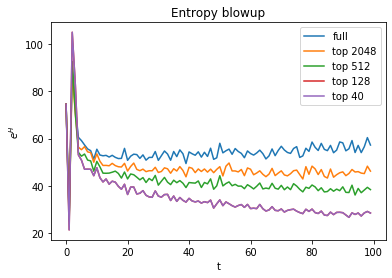

In [31]:
plt.plot(np.exp(save_ents[0, :]), label='full')
plt.plot(np.exp(save_ents[1, :]), label='top 2048')
plt.plot(np.exp(save_ents[2, :]), label='top 512')
plt.plot(np.exp(save_ents[3, :]), label='top 128')
plt.plot(np.exp(save_ents[4, :]), label='top 40')
plt.xlabel('t')
plt.ylabel('$e^H$')
plt.legend()
plt.title('Entropy blowup')

In [36]:
np.savez('cache_2', save_ents=save_ents)

In [37]:
# probing what happens to top 40 as we go for longer
length = 150
k = 40

with torch.no_grad():
    avg_ents = torch.zeros((1, length), device=device)
    i = 0
    with open(file) as fp:
        for line in fp:
            context = tokenizer.encode(line)
            ents = sample_sequence_batch(
                model=model,
                context=context,
                length=length,
                tokenizer=tokenizer,
                temperature=1,
                top_k=k,
                top_p=0.0,
                batch_size=32,
                num_samples=128,
                is_xlnet=False,
                device=device
            )
            ents = ents.mean(axis=0)
            avg_ents = (avg_ents * i + ents) / (i + 1)
            i += 1

100%|██████████| 150/150 [00:16<00:00,  5.57it/s]


100%|██████████| 150/150 [00:16<00:00,  5.57it/s]


In [38]:
np.savez('top40_long', avg_ents=avg_ents.cpu().numpy())

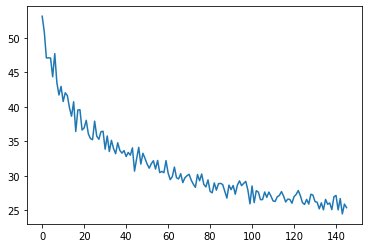

In [42]:
test = avg_ents.cpu().numpy()[0]
plt.plot(np.exp(test[4:]))